# Simulation of the ferromagnet Pb2VO(PO4)2, Using SQW4-component

The files necessary to perform the simulation are generated using the SpinW software, and the exchange parameters and model are taken from literature. 

In [1]:
#More complex example of pyMACS usage

import numpy as np
import pyMACS
from pyMACS.virtualMACS import VirtualMACS
import mcstasscript as ms

macs= VirtualMACS('pdvpo_experiment',cifName='Pb2VO_PO4_2.cif',useOld=True)
macs.sample.formula_weight=671.3
numthreads=8


This is a more complex example of the usage of the pyMACS interface, which 
simulates a real experiment from start to finish. The system of choice is 
Pb2VO(PO4)2, which has a well defined spin hamiltonian and MACS data to directly compare to. The system was simulated using
SpinW, with the spin interactions defined by the following work 

https://journals.aps.org/prb/pdf/10.1103/PhysRevB.99.184437

The sample is assumed to be larger than is realistic, to give appreciable intensity
from spin waves. 

In [2]:
#Going to make our sample artifically big to increase count rate. 
macs.sample.sample_widx=0.01
macs.sample.sample_widy=0.01
macs.sample.sample_widz=0.01

macs.monochromator.Ei = 3.7
macs.monochromator.Ef = 3.7
macs.sample.cif2lau()

#Sample is aligned in the HK0 plane
macs.sample.orient_u=[1,0,0]
macs.sample.orient_v=[0,1,0]
macs.sample.project_sample_realspace()
print('Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]')
print(macs.sample.labframe_mat)
print('')
print('Structure factors:')
print('|F(110)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,1,0)[3],4))+' barn')
print('|F(100)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,0,0)[3],4))+' barn')
print('|F(1-10)|^2 = '+str(round(macs.sample.fetch_F_HKL(1,-1,0)[3],4))+' barn')
print('|F(001)|^2 = '+str(round(macs.sample.fetch_F_HKL(0,0,1)[3],4))+' barn')

print('sigma_abs ='+str(macs.sample.rho_abs)+' barn/unit cell')
print('sigma_inc ='+str(macs.sample.sigma_inc)+' barn/unit cell')

 
Conversion of CIF to crystallographical LAU file successful. 
Real Space projection of lattice vectors [ax,ay,az; bx,by,bz;cx,cy,cz]
[[ 8.58746  1.66301  0.     ]
 [-0.       0.       9.016  ]
 [ 0.      -9.863    0.     ]]

Structure factors:
|F(110)|^2 = 3.0769 barn
|F(100)|^2 = 0.0 barn
|F(1-10)|^2 = 3.0769 barn
|F(001)|^2 = 0.6482 barn
sigma_abs =23.07084 barn/unit cell
sigma_inc =5.1032 barn/unit cell


## Single Crystal SQW4 process. 

pyMACS includes an experimental UNION process, the Sqw4_process. It will work out of the box, and behaves very similarly to the single_crystal_process. It is essentially a port of Single_crystal_inelastic.comp by Duc Le. 

In [3]:
import os
import shutil
#To use the sqw4 process, it requires the copying of the component into the current directory. 
if not os.path.exists("Sqw4_process.comp"):
    shutil.copy(macs.instr_template_dir+"Sqw4_process.comp","Sqw4_process.comp")





In [4]:
#MACS can't actually access the full spinwave spectrum of this system, we will only 
# look at energy transfers below 12 meV. Ei_max = 17 meV

# In this example, the sample has three different scattering processes. 
# Bragg diffraction, incoherent scattering, and spin waves. 

scattering_def = ms.McStas_instr("scattering_definition",checks=False)
inc_scatter = scattering_def.add_component("inc_scatter","Incoherent_process")
inc_scatter.sigma=macs.sample.sigma_inc
inc_scatter.unit_cell_volume = macs.sample.cell_vol
inc_scatter.packing_factor = 1
inc_scatter.interact_fraction=1
inc_scatter.set_AT([0,0,0])

#Single crystal process. 
crystal_scatter = scattering_def.add_component("crystal_scatter","Single_crystal_process")
crystal_scatter.delta_d_d=0.005
crystal_scatter.mosaic = 30.0
#Projections of lattice vectors onto lab frame is handled by the previous helper process.
labproj = macs.sample.labframe_mat
crystal_scatter.ax = labproj[0,0]
crystal_scatter.ay = labproj[0,1]
crystal_scatter.az = labproj[0,2]
crystal_scatter.bx =labproj[1,0]
crystal_scatter.by = labproj[1,1]
crystal_scatter.bz = labproj[1,2]
crystal_scatter.cx = labproj[2,0]
crystal_scatter.cy = labproj[2,1]
crystal_scatter.cz = labproj[2,2]
crystal_scatter.reflections='\"'+"Pb2VO_PO4_2.lau"+'\"'
crystal_scatter.barns=1
crystal_scatter.packing_factor=1
crystal_scatter.powder=0
crystal_scatter.PG=0
crystal_scatter.interact_fraction=1
crystal_scatter.set_AT([0,0,0])
crystal_scatter.set_ROTATED([0,0,0])

#Sample sqw4 processs
sample_sqw4 = scattering_def.add_component("sample_sqw4", "Sqw4_process")
sample_sqw4.sqw = '"spinw_PbVOPO_full.sqw4"'
#This file must also be added to the instrument file dependencies to be copied correctly.
macs.file_dependencies="spinw_PbVOPO_full.sqw4"
#We are choosing to have the (100) vector along the x-axis
sample_sqw4.ax=labproj[0,0]
sample_sqw4.ay=labproj[0,1]
sample_sqw4.az=labproj[0,2]
sample_sqw4.bx=labproj[1,0]
sample_sqw4.by=labproj[1,1]
sample_sqw4.bz=labproj[1,2]
sample_sqw4.cx=labproj[2,0]
sample_sqw4.cy=labproj[2,1]
sample_sqw4.cz=labproj[2,2]
sample_sqw4.aa=macs.sample.alpha
sample_sqw4.bb=macs.sample.beta
sample_sqw4.cc=macs.sample.gamma
sample_sqw4.barns=1
sample_sqw4.max_stored_ki=1e5
sample_sqw4.max_bad=1e5
sample_sqw4.stored_dTheta = 0.1
sample_sqw4.stored_dkmag = 1e-4
sample_sqw4.recip_cell=0
sample_sqw4.interact_fraction=1
#sample_sqw4.init="'init'"
#sample_sqw4.append_EXTEND("// Remove direct beam\nif(!SCATTERED) ABSORB;")
sample_sqw4.set_AT([0,0,0])
sample_sqw4.set_ROTATED([0,0,0])

scattering = scattering_def.add_component("PbVPO","Union_make_material")
scattering.process_string='"crystal_scatter,inc_scatter,sample_sqw4"'
scattering.my_absorption=macs.sample.rho_abs
scattering.set_AT([0,0,0])

#Now, this pseudo-instrument will be saved as the scattering definition of the sample. 
macs.sample.scattering_def = scattering_def

#Make a second object for the geometry. This particular case replicates the validation experiment for this package.
geo_def = ms.McStas_instr("geometry_definition",checks=False)

sample_cube=geo_def.add_component("sample_cube","Union_box")
sample_cube.xwidth=1.0*macs.sample.sample_widx
sample_cube.yheight=1.0*macs.sample.sample_widy
sample_cube.zdepth=1.0*macs.sample.sample_widz
sample_cube.priority=100
sample_cube.material_string='\"PbVPO\"'
sample_cube.number_of_activations="number_of_activations_sample" #Do not change. 
sample_cube.set_AT([0,0,0],RELATIVE='crystal_assembly')
sample_cube.set_ROTATED([0,0,0],RELATIVE='crystal_assembly')

sample_plate = geo_def.add_component("sample_plate","Union_cylinder")
sample_plate.radius=0.006
sample_plate.yheight=0.002
sample_plate.priority=40
sample_plate.material_string='"Al"'
plate_distance = macs.sample.sample_widy+0.002
sample_plate.set_AT([0,plate_distance,0],RELATIVE="target")
sample_plate.set_ROTATED([0,0,0],RELATIVE="target")

sample_plate_rod = geo_def.add_component("sample_plate_rod","Union_cylinder")
sample_plate_rod.radius=0.00125
sample_plate_rod.yheight=0.0633
sample_plate_rod.priority=41
sample_plate_rod.material_string='"Al"'
sample_plate_rod.set_AT([0,plate_distance+0.001+0.031,0], RELATIVE="target")
sample_plate_rod.set_ROTATED([0,0,0],RELATIVE="target")

sample_base = geo_def.add_component("sample_base","Union_cylinder")
sample_base.radius=0.0065
sample_base.yheight=0.013
sample_base.priority=42
sample_base.material_string='\"Al\"'
sample_base.set_AT([0,0.0628,0],RELATIVE="target")
sample_base.set_ROTATED([0,0,0],RELATIVE="target")

sample_base_gap = geo_def.add_component("sample_base_gap","Union_cylinder")
sample_base_gap.radius=0.004
sample_base_gap.yheight=0.009
sample_base_gap.priority=43
sample_base_gap.material_string='"Vacuum"'
sample_base_gap.set_AT([0,0.0668,0], RELATIVE="target")
sample_base_gap.set_ROTATED([0,0,0],RELATIVE="target")

macs.sample.geometry_def = geo_def

In [5]:
#Some housekeeping steps needed for simulation
macs.prepare_expt_directory()
macs.edit_instr_file()
macs.compileMonochromator()
macs.compileInstr()

/mnt/c/Users/tjh/OneDrive - NIST/GitHub/pyMACS/docs/source/notebooks
#################

Starting compilation of monochromator.

Compilation of monochromator geometry successful.

#################

#################

Starting compilation of sample kidney geometry.

Compilation of sample kidney geometry successful.

#################



1

Perform the actual scan. This will take a long time.

In [35]:
#Style sheet updates 
import matplotlib.pyplot as plt

plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['font.size']=10
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
plt.rcParams['text.usetex']=False
plt.rcParams['font.family']='serif'
plt.close('all')

In [ ]:
#A note about file sizes here - a single 1e8 monochromator scan will make a 
# 350 Mb output file for Ef=5.0, ~100 Mb for Ef=3.7, so just be aware of this.
macs.n_mono=1e8
macs.n_sample=1e6

#The object is now set up and ready to perform simulations. 
# Copy experimental details from paper
macs.kidney.Ef=3.7
macs.kidney_angle_resolution=0.8
Ei_list = 3.7+np.array([0.5,1.0,1.5,1.75,2,2.25])

macs.preserve_kidney_scan_files=False
macs.script_scan(A3_list=np.arange(-108,84,1),Ei_list=Ei_list,\
                    num_threads=8,scan_title="PbVPO_a3scan_cube")

macs.data.load_data_matrix_from_csv("PbVPO_a3scan_cube_dataMatrix.csv")
macs.data.write_data_to_ng0(f"PbVPO_a3scan_cube.ng0")


Total Scans:   0%|          | 0/6 [00:00<?, ?it/s]

Ei=4.2 meV:   0%|          | 0/12 [00:00<?, ?it/s]


KeyboardInterrupt



/tmp/ipykernel_6528/3632188985.py:35: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


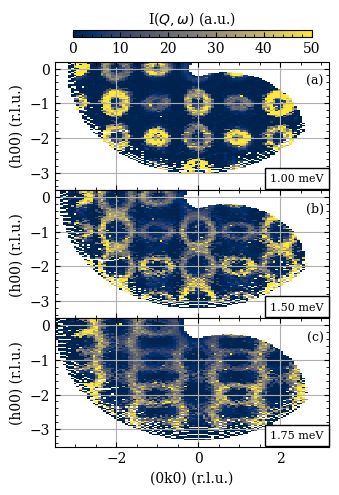

In [62]:
# Make a plot for paper, similar to the one in the paper. 
import matplotlib
fig,axs = plt.subplots(3,1,figsize=(3.54,5))

E_slices = [1.0,1.5,1.75]
plot_labels=['(a)','(b)','(c)']
for i,E in enumerate(E_slices):
    macs.data.project_data_QE(viewing_axes=[[1,0,0],[0,1,0]])
    Qu_el, Qv_el, I_el, Err_el = macs.data.take_slice([-3.5,0.2,100],[-3.5,3,100],[E-0.1,E+0.1],which_data='mcstas')
    mesh = axs[i].pcolormesh(Qv_el,Qu_el,I_el.T,vmin=0,vmax=5e1,cmap='cividis',rasterized=True)
    axs[i].set_xlim(-3.5,3.2)
    axs[i].set_ylim(-3.5,0.2)
    axs[i].grid()
    axs[i].set_ylabel("(h00) (r.l.u.)")
    axs[i].text(0.98,0.05,f"{E:.2f} meV",fontsize=8,
                bbox=dict(facecolor='w', edgecolor='k'),transform=axs[i].transAxes,
               horizontalalignment='right',verticalalignment='bottom')
    axs[i].text(0.98,0.8,f"{plot_labels[i]}",fontsize=9,
                transform=axs[i].transAxes,
               horizontalalignment='right',verticalalignment='bottom')
fig.subplots_adjust(hspace=0,wspace=0)
axs[2].set_xlabel("(0k0) (r.l.u.)")

#Make color bar
l,b,w,h=axs[0].get_position().bounds
cax_a = fig.add_axes([l+0.05,b+h+0.05,w-0.1,h*0.05])
labelstr='I($Q,\omega$) (a.u.)'
cbar_a = plt.colorbar(mesh,orientation='horizontal',cax=cax_a)
cax_a.text(0.5,1.5,labelstr,transform=cax_a.transAxes,horizontalalignment='center',verticalalignment='bottom',
        rotation=0,fontsize=10)
cax_a.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter("%.1f"))
cax_a.tick_params(labelleft=False,labelright=True,labelsize=10)
cax_a.set_yticks([])
fig.savefig("pymacs_pbvopo4_sim.pdf",bbox_inches='tight',dpi=300)
fig.show()